# Práctico N° 2 Análisis de Grafos - Actividad 5 y 6

Integrantes: Nicolás Benjamín Ocampo, Antonela Sambuceti

En este práctico, trabajaremos con un dataset extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

## Configuración inicial

In [50]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 6.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 7.4 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 316 kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 376 kB/s 
     |████████████████████████████████| 325 kB 6.5 MB/s 
     |████████████████████████████████| 407 kB 56.1 MB/s 
     |████████████████████████████████| 45 kB 3.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=64e0bbabd7889b61dd164c9896e6215b26351c772f0c4b97a827612ce89ea62b
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built to

In [44]:
pip install igraph

     |████████████████████████████████| 3.2 MB 7.7 MB/s 


In [51]:
import pandas as pd
import numpy as np
import io

import seaborn as sn
import matplotlib.pyplot as plt
import math
#from cdlib import NodeClustering, evaluation, algorithms
import igraph as ig
import networkx as nx
import pickle

from nltk import (corpus, tokenize, download)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
download("stopwords")
download('punkt')

import numpy as np
import networkx as nx

from torch_geometric.nn import Node2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Cargamos el dataset

In [33]:
from google.colab import files
uploaded = files.upload()

Saving larg_G.edgelist to larg_G.edgelist


In [40]:
larg_G = nx.read_edgelist('larg_G.edgelist')

In [41]:
larg_G

## Actividades

## 5. Embedding de nodos
Generar un embedding del grafo de retweets utilizando el algoritmo word2vec.
Reducir a 2 la dimensionalidad del embedding utilizando PCA y t-SNE.
Graficar los embeddings correspondientes a los datos etiquetados. ¿Es posible diferenciar unos de otros?

In [52]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


Matrices esparsas

In [54]:
adj = nx.to_scipy_sparse_matrix(larg_G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

Node2Vec

In [72]:
## Definimos nuestro modelo
model = Node2Vec(
    edge_index, embedding_dim=200, walk_length=20, 
    context_size=4, num_negative_samples=10
).to(device)

## El loader es un wrapper que nos permite trabajar por lotes, 
## para utilizar descenso por el gradiente estocástico y
## sus variantes
loader = model.loader(batch_size=128, shuffle=True)

## Optimizador
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

In [73]:
def train():
    ## Ponemos nuestro modelo en modo entrenamiento
    model.train()

    total_loss = 0
    for pos_rw, neg_rw in loader:

        ## Reseteamos los gradientes
        optimizer.zero_grad()

        ## Calculamos el error (la función de costo) del lote
        ## en función de los samples positivos y negativos
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))

        ## Hacemos backpropagation
        loss.backward()

        ## Avanzamos un paso
        optimizer.step()

        ## Actualizamos la función de costo total
        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
epochs = 50
for epoch in range(epochs):
    loss = train()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3} - Loss: {loss:.3f}')

Epoch:   0 - Loss: 8.799
Epoch:   5 - Loss: 1.687
Epoch:  10 - Loss: 0.902


In [60]:
def get_embedding():
    model.eval()
    with torch.no_grad():
        nodes = torch.arange(larg_G.number_of_nodes(), device=device)
        embedding = model(nodes).detach().numpy()
    return embedding

embedding = get_embedding()

In [61]:
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)

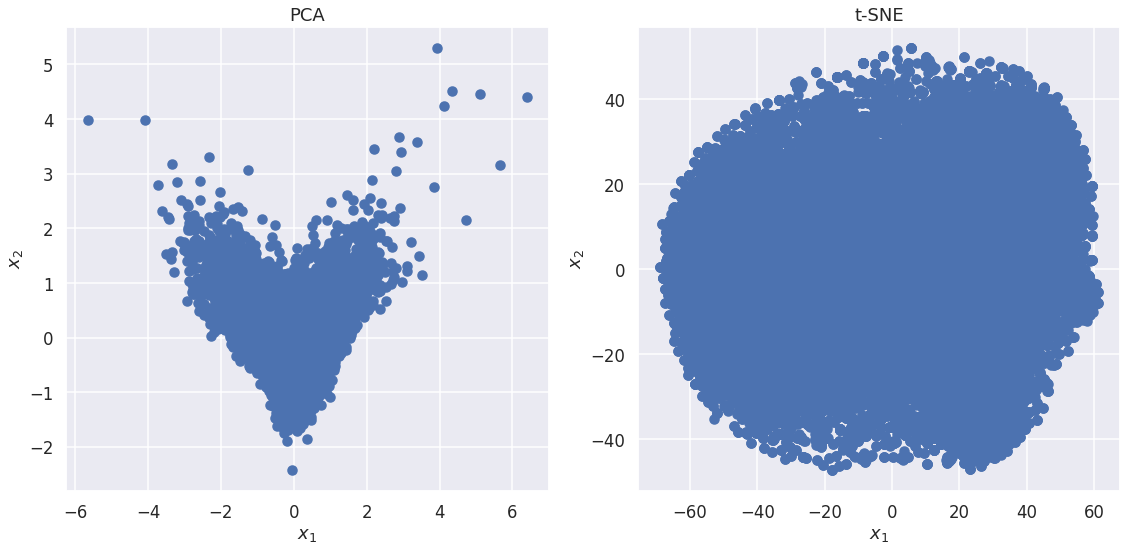

In [71]:
#def add_labels(larg_G, pos, ax):
#   labels = [v for v in larg_G.nodes()]
#    for i in range(larg_G.number_of_nodes()):
#        x, y = pos[i]
#        label = labels[i]
#        ax.text(x, y, label)

#color = ['C0' if elem == 'Mr. Hi' else 'C1' for elem in membership]
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols, 8), ncols=2)
ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('PCA')
ax.scatter(pca[:,0], pca[:,1])
#add_labels(larg_G, pca, ax)
ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
ax.scatter(tsne[:,0], tsne[:,1])
#add_labels(larg_G, tsne, ax)
plt.tight_layout()
plt.show()

## Opcional: 
Graficar además los embeddings de los nodos que forman parte de las comunidades asociadas a cada clase. Determinar si el embedding permite distinguir cada comunidad.

## Opcional: 6. Redes neuronales de grafos
El archivo word_vectors.csv contiene un embedding de 300 dimensiones para cada tweet, otenido utilizando un modelo preentrenado de FastText. Construir una matriz de features para los nodos tomando, para cada usuario, el promedio de los vectores correspondientes a los tweets que escribió. Utilizando estos features, y tomando como ejemplos etiquetados los usuarios de "etiquetas.csv" entrenar una red neuronal de grafos para realizar una clasificación binaria sobre el resto de los nodos. Pueden utilizar como base el siguiente modelo:

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Embedding final
        
        # Aplicamos un clasificador lineal sobre el embedding
        out = self.classifier(h)

        return out, h

Observación: para alimentar la red neuronal, es necesario construir un objeto de la clase Dataset de PyTorch-Geometric. Una forma de hacer eso es la siguiente

In [ ]:
from torch_geometric.data import InMemoryDataset, Data

## Reemplazar por el grafo correspondiente
g = nx.Graph()

## Etiquetas. Reemplazar por las clases del archivo 'etiquetas.csv'.
## Asignar la clase '2' a los ejemplos no etiquetados
labels = [1, 0, 2, ..., 1]

## True si el ejemplo está etiquetado (clases 0 y 1)
train_idx = [True, True, False, ..., True]

## Matriz de features (word vectors)
features = ...

adj = nx.to_scipy_sparse_matrix(g).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)


class TwitterDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(TwitterDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = g.number_of_nodes()
        
        # Features 
        data.x = torch.from_numpy(features).type(torch.float32)
        
        # Etiquetas
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2
        
        n_nodes = g.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[train_idx] = True
        data['train_mask'] = train_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)